<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/part13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GELU Activation Function

- Part of feed forward block. We will implement this neural network sub-module.

- The activation functions commonly implemented in LLms are GELU and SwiGLU.

- ReLU(x) = max(0,x)

- Not differentiable at x=0, and it leads to dead neuron problem when output is negative and ReLU mark it as zero. Those neurons will not contribute in learning.

- GeLU = x * phi(x)

- phi(x) = CDF of standard gaussian distribution.

- high value of x as CDF is close to 1 GeLU(x) = x

- negative values of x, CDF is not zero so GeLU(x) = negative value

- GeLU activation function approximation used for training GPT-2.

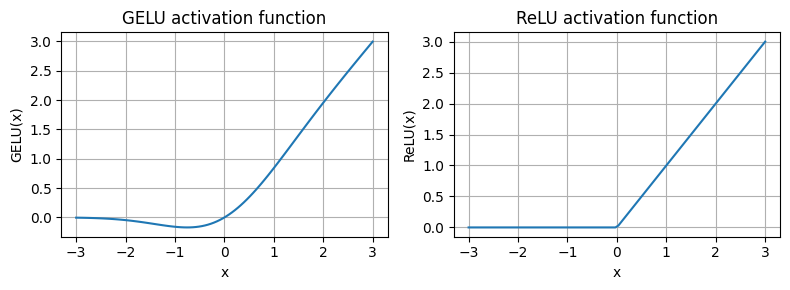

In [12]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

Benefits of GELU over ReLU

- The smoothness of GELU, as shown in the above figure, can lead to better optimization properties
during training, as it allows for more nuanced adjustments to the model's parameters.

- In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder,
especially in networks that are very deep or have complex architectures.

- Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output
for negative values.

- This characteristic means that during the training process, neurons that
receive negative input can still contribute to the learning process, albeit to a lesser extent
than positive inputs.


In [13]:
import torch
import torch.nn as nn

class GELU(nn.Module):
  def __init__(self) -> None:
    super().__init__()

  def forward(self, x):
    # approx GeLu function
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

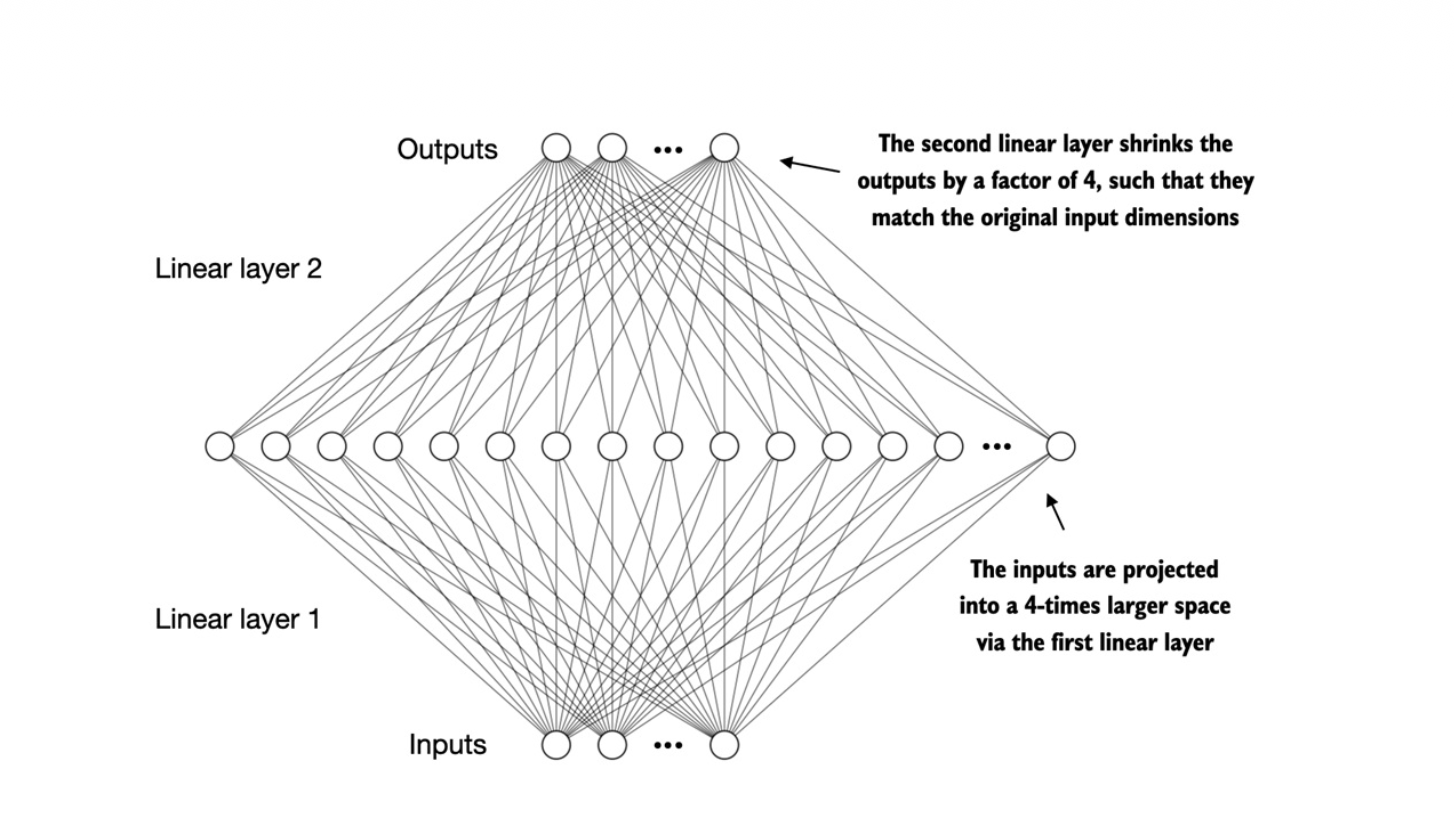

Figure shows the expansion and contraction of the layer outputs in the feed forward neural network. First, the inputs expand by a factor of 4 from 768 to 3072 values. Then, the second layer compresses the 3072 values back into a 768-dimensional representation.

Expansion and contraction allows rich exploration space. We can capture more properties because of this.

We can visualize it like it is taking one token and modifying each dimension of this token. Here we are looking into one token at a time different from attention mechanism where we consider other tokens to find relationship.

Summary

shape - (batch, token, dim)
1. Linear layer - Input: (2,3,768), Output: (2,3,3072)
2. GELU activation - Input: (2,3,3072), Output: (2,3,3072)
3. Linear layer - Input: (2,3,3072), Output: (2,3,768)
     

In [14]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [20]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # layers in a sequential are connected in a cascading way,
        # output of the first will become input for the second and so on.
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # Expansion
            GELU(),                                         # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),  # Contraction
        )

    def forward(self, x):
      return self.layers(x)

In [18]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [19]:
print(nn.Linear(2, 3))

Linear(in_features=2, out_features=3, bias=True)


The FeedForward module we implemented in this section plays a crucial role in enhancing the model's ability to learn from and generalize the data.


Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher-dimensional space through the first linear layer.

This expansion is followed by a non-linear GELU activation, and then a contraction back to the original dimension with the second linear transformation.

Such a design allows for the exploration of a richer representation space.

The uniformity in input and output dimensions simplifies the architecture by enabling the stacking of multiple layers, as we will do later, without the need to adjust dimensions between them, thus making the model more scalable.